<a href="https://colab.research.google.com/github/jenniesun/biostats-blog/blob/main/assignment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image Classification and SHapley Additive exPlanations
This notebook trains a deep learning model to classify beetles, cockroaches and dragonflies using these images. Note: Original images from https://www.insectimages.org/index.cfm. 

The blog that explains the process as well as how the neural network classified the images using SHapley Additive exPlanations and be found here: https://jenniesun.github.io/biostats-blog/


In [1]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


## Imports:

Start by importing the necessary PyTorch modules.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch version:", torch.__version__)

PyTorch version: 1.10.0+cu111


## Setup device
If GPUs (w/ CUDA) are available we will use them. If not, set the device to CPU. Initializing the `device` object this way makes the code system agnostic.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


## Define Model
Next, we will build a small custom CNN.

When building a model, we make it a sub-class of `nn.Module` and override two functions: `__init__` and `forward`:
- `__init__` is the model constructor. Here, we first call the parent's constructor then define our layers. This can be thought of as creating the nodes of our computational graph.
- `forward` defines the forward pass of our network. In other words, this defines the connections between the nodes (layers) of our computation graph. Must return a tensor.

In [4]:
# Define MyNet model class
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # First conv layer should expect 1 input channel, as MNIST images are greyscale
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        # conv2's in_channels should match conv1's out_channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # Note that before passing conv2's output to fc1 we will flatten it
        # So the input size will be feature_height*feature_width*feature_depth 
        # We can compute this by hand (note input is 1x28x28): 64x7x7=3136)
        self.fc1 = nn.Linear(in_features=(200704), out_features=128)
        # This is the last FC layer, so the output size must == num_classes == 10
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        # Forward thru conv1
        x = self.conv1(x)
        # Apply ReLU activation on the output
        x = F.relu(x)
        # Downsample feature's spatial extent w/ max pool
        x = F.max_pool2d(x, kernel_size=2)
        
        # Forward thru conv2
        x = self.conv2(x)
        # Apply ReLU activation on the output
        x = F.relu(x)
        # Downsample feature's spatial extent w/ max pool
        x = F.max_pool2d(x, kernel_size=2)
        
        # Flatten conv feature here
        x = torch.flatten(x, 1)
        # Forward thru fc1
        x = self.fc1(x)
        # Apply ReLU activation on the output
        x = F.relu(x)
        # Forward thru fc2
        x = self.fc2(x)
        return x
    

# Construct a MyNet instance on the correct device
model = MyNet().to(device)
# Print nodes in model's graph
print(model)

MyNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)


## Initialize loss function and optimizer

The next step is to initialize our loss function (`criterion`) and optimizer.
- For the `criterion` we use `nn.CrossEntropyLoss`, which combines `nn.LogSoftmax` with `nn.NLLLoss`.
- We use an `SGD` optimizer with learning rate 0.01.

In [5]:
# Construct loss function object
criterion = nn.CrossEntropyLoss().to(device)

# Construct optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Prepare data and data loading process

In this example we are training an insect classifier. 

Now that we have our model and learning criterion established, we can prepare the data and data loading process. The first step is to define our `transform` class where we define the input preprocessing that we desire for each input. In our case, we simply convert the data to a tensor and normalize the data about the precalculated mean and std of each channel in the training set (this can usually be looked up). 

The next step is to construct PyTorch `Datasets`, which stores the data in memory. We set the `download` flags to true, which will download the data to the specified path if PyTorch cannot find already find it there.

We also need to construct a `DataLoader`s for both the train and test `Dataset`. The role of the `DataLoader` is to wrap an iterable around the `Dataset` so that we can easily serve the data up in batches. This is where we set the batch size, and `shuffle` flag. Typically, we shuffle training data to help with convergence.

In [6]:
# Define preprocessing
transform=transforms.Compose([
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5946,0.5732,0.5126), std=(0.2671,0.2737, 0.3058))
        ])

transform_base=transforms.Compose([
        transforms.Resize(size = (224, 224)),
        transforms.ToTensor()
        ])

In [7]:
!unzip gdrive/My\ Drive/data/insects.zip > /dev/null

In [8]:
base_dir = './insects'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [9]:
# Load data into datasets
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(test_dir, transform=transform)

val_dataset_base = datasets.ImageFolder(test_dir, transform=transform_base)

In [10]:
# Construct dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=32, 
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(val_dataset, 
                                          batch_size=32, 
                                          shuffle=False,
                                          num_workers=2)
base_loader = torch.utils.data.DataLoader(val_dataset_base,
                                          batch_size=128,
                                          shuffle=True,
                                          num_workers=2)

## Visualize data

Here we investigate what a batch of our training data looks like.

Notice that our `images` tensor contains the normalized image data, and has shape NxCxHxW, and the `targets` tensor is essentially a list of corresponding target class labels with shape N (batch_size).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images: tensor([[[ 1.0186,  1.0333,  1.0186,  ...,  1.0186,  1.0039,  1.0333],
         [ 1.0333,  1.0333,  1.0333,  ...,  1.0186,  1.0186,  1.0333],
         [ 1.0333,  1.0333,  1.0186,  ...,  1.0186,  1.0186,  1.0333],
         ...,
         [ 1.0480,  1.0480,  1.0480,  ..., -2.2261, -2.2261, -2.2261],
         [ 1.0626,  1.0626,  1.0626,  ..., -2.2261, -2.2261, -2.2261],
         [ 1.0480,  1.0480,  1.0480,  ..., -2.2261, -2.2261, -2.2261]],

        [[ 1.0865,  1.0722,  1.0722,  ...,  1.0722,  1.0579,  1.0865],
         [ 1.0865,  1.0865,  1.0865,  ...,  1.0722,  1.0722,  1.0865],
         [ 1.0865,  1.0865,  1.0865,  ...,  1.0722,  1.0722,  1.0865],
         ...,
         [ 1.1152,  1.1295,  1.1009,  ..., -2.0943, -2.0943, -2.0943],
         [ 1.1152,  1.1152,  1.1152,  ..., -2.0943, -2.0943, -2.0943],
         [ 1.1009,  1.1009,  1.1009,  ..., -2.0943, -2.0943, -2.0943]],

        [[ 1.2091,  1.2091,  1.1963,  ...,  1.1835,  1.1707,  1.1963],
         [ 1.1963,  1.1963,  1.1963, 

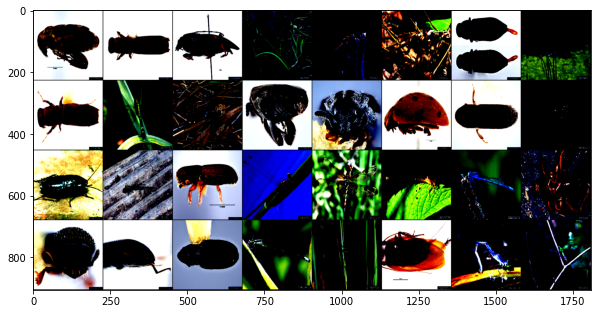

In [11]:
# Grab a batch of training data
images, targets = next(iter(train_loader))
print("images:", images[0], images.shape)
print("targets:", targets, targets.shape)

# Plot grid of images
grid_img = torchvision.utils.make_grid(images, 8)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Train model

Finally we can train our model. 

Training is typically done by looping over a specified number of epochs. In each epoch, we iterate over all batches of the training data and update the model. 

Note that for each batch, we must:
- Move data to correct device.
- Zero out old gradients (they accumulate by default).
- Forward pass input through model.
- Compute loss w.r.t. the current targets.
- Backward pass the loss to get compute gradients.
- Update parameters using gradients and our optimizer.

In [12]:
epochs = 10

for i in range(1, epochs+1):
    # Put model in train mode
    model.train()
    print("\nEpoch [{}/{}]".format(i, epochs))

    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0
    
    # Train the training dataset for 1 epoch.
    for batch_idx, (images, targets) in enumerate(train_loader):
        # Copy inputs to device
        images = images.to(device)
        targets = targets.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass images through model
        outputs = model(images)
        # Compute loss
        loss = criterion(outputs, targets)
        # Now backward loss
        loss.backward()
        # Apply gradient
        optimizer.step()
        # Calculate correct predictions
        _, predicted = torch.max(outputs, 1)
        #print("targets:", targets, targets.shape)
        #print("predicted:", predicted, predicted.shape)
        correct = predicted.eq(targets).sum()
        #print("correct:", correct)
        # Append to totals
        total_ims += targets.shape[0]
        total_batches += 1
        total_loss += loss
        total_corrects += correct.item()
        # Print every 32 batches
        if batch_idx % 32 == 0:
            print("batch: {}".format(batch_idx), "\tloss: {}".format(loss.item()))
    
    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0

    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, acc))



Epoch [1/10]
batch: 0 	loss: 1.1049938201904297
Training loss: 0.7486, Training accuracy: 67.9097

Epoch [2/10]
batch: 0 	loss: 0.8108844757080078
Training loss: 0.5229, Training accuracy: 79.5878

Epoch [3/10]
batch: 0 	loss: 0.3662196099758148
Training loss: 0.4428, Training accuracy: 82.9244

Epoch [4/10]
batch: 0 	loss: 0.3206356167793274
Training loss: 0.4176, Training accuracy: 83.4151

Epoch [5/10]
batch: 0 	loss: 0.4283587634563446
Training loss: 0.3599, Training accuracy: 86.0648

Epoch [6/10]
batch: 0 	loss: 0.282236784696579
Training loss: 0.3655, Training accuracy: 86.0648

Epoch [7/10]
batch: 0 	loss: 0.29429537057876587
Training loss: 0.3379, Training accuracy: 86.4573

Epoch [8/10]
batch: 0 	loss: 0.19280783832073212
Training loss: 0.2915, Training accuracy: 88.6163

Epoch [9/10]
batch: 0 	loss: 0.13502417504787445
Training loss: 0.2641, Training accuracy: 90.4809

Epoch [10/10]
batch: 0 	loss: 0.15953481197357178
Training loss: 0.2781, Training accuracy: 90.1865


## Test model

Now that we have a trained model, we can test its performance on the test set.

To do this we use a similar loop to our training procedure, but we do not need to compute gradients or update the model.

In [13]:
# Make this a function so we can re-use later (can do this for training too)

def test_model(model):

    total_ims = 0
    total_batches = 0
    total_loss = 0
    total_corrects = 0

    # Put model in eval mode
    model.eval()

    # Do NOT compute gradients
    with torch.no_grad():
        # Run inference on each image in the test set (use batches to make process faster)
        for batch_idx, (images, targets) in enumerate(test_loader):
            # Copy inputs to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass images through model
            outputs = model(images)
            # Compute loss
            loss = criterion(outputs, targets)
            # Calculate correct predictions
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            # Append to totals
            total_ims += targets.shape[0]
            total_batches += 1
            total_loss += loss
            total_corrects += correct.item()

    avg_loss = total_loss / total_batches
    acc = (total_corrects / total_ims) * 100.0

    print("Test loss: %.4f, Test accuracy: %.4f" %(avg_loss, acc))

    
# Call test_model
test_model(model)

Test loss: 0.3198, Test accuracy: 86.1111


In [14]:
total_corrects

919

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images: tensor([[[ 1.2535,  1.2682,  1.2682,  ...,  1.2682,  1.2829,  1.2829],
         [ 1.2535,  1.2535,  1.2682,  ...,  1.2682,  1.2682,  1.2682],
         [ 1.2535,  1.2535,  1.2535,  ...,  1.2682,  1.2682,  1.2682],
         ...,
         [ 1.0186,  1.0186,  1.0186,  ..., -2.2261, -2.2261, -2.2261],
         [ 1.0186,  1.0186,  1.0186,  ..., -2.2261, -2.2261, -2.2261],
         [ 1.0186,  1.0186,  1.0186,  ..., -2.2261, -2.2261, -2.2261]],

        [[ 1.3015,  1.3158,  1.3015,  ...,  1.3158,  1.3301,  1.3301],
         [ 1.3015,  1.3015,  1.3158,  ...,  1.3158,  1.3158,  1.3158],
         [ 1.3015,  1.3015,  1.3015,  ...,  1.3158,  1.3158,  1.3158],
         ...,
         [ 1.0722,  1.0722,  1.0722,  ..., -2.0943, -2.0943, -2.0943],
         [ 1.0722,  1.0722,  1.0722,  ..., -2.0943, -2.0943, -2.0943],
         [ 1.0722,  1.0722,  1.0722,  ..., -2.0943, -2.0943, -2.0943]],

        [[ 1.3630,  1.3758,  1.3758,  ...,  1.3758,  1.3887,  1.3887],
         [ 1.3630,  1.3630,  1.3758, 

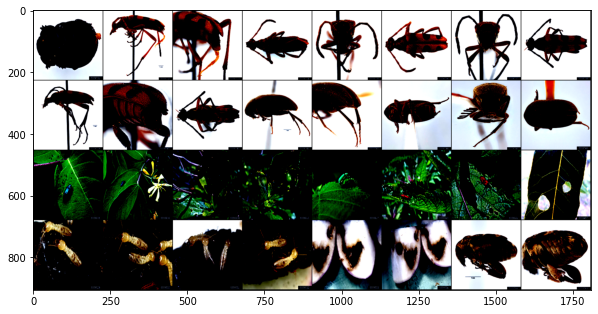

In [15]:
# Grab a batch of testing data
images, targets = next(iter(test_loader))
print("images:", images[0], images.shape)
print("targets:", targets, targets.shape)

# Plot grid of images
grid_img = torchvision.utils.make_grid(images, 8)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize = (10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [16]:
classes = ('beetles', 'cockroach', 'dragonflies')
print('GroundTruth: ', ' '.join('%5s' % classes[targets[j]] for j in range(10)))

GroundTruth:  beetles beetles beetles beetles beetles beetles beetles beetles beetles beetles


### What are the classes that performed well, and the classes that did not perform well?

In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data    
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

  
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class beetles is: 83.3 %
Accuracy for class cockroach is: 75.0 %
Accuracy for class dragonflies is: 100.0 %


## Interpretable deep learning

This is modeled closely after the example in the official `shap` repository.

In [21]:
import shap

In [22]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(base_loader))
images, labels = batch

background = images[:100].to(device)
test_images = images[100:103].to(device)

e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(test_images)

shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.detach().cpu().numpy(), 1, -1), 1, 2)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


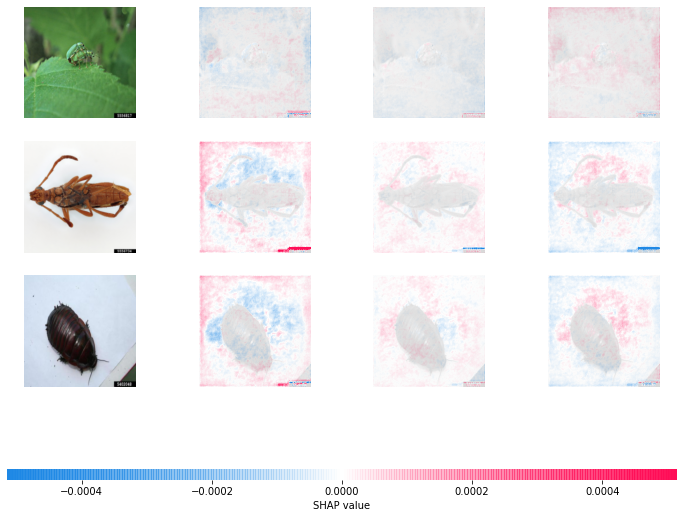

In [23]:
# plot the feature attributions
shap.image_plot(shap_numpy, np.transpose(test_images.cpu().data.numpy(),(0,2,3,1)))

## Saving and loading models

The last basic procedure that we will cover is how to save and load PyTorch models. 

In this example, we wish to save the model to disk to be used for inference later. To do this, we simply use `torch.save` to save the model's `state_dict`, which is a Python dictionary that contains all of the parameters of the module.



For a detailed outline on the many ways to save and load models (e.g., save/load across devices, save/load for finetuning, etc.), see the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/saving_loading_models.html). 

In [24]:
# Save model
torch.save(model.state_dict(), "./insect_classifier_model.pt")

To demonstrate the loading process we will construct a new `MyNet`, test it, then load the saved parameters and re-test to prove that the parameters loaded correctly.

In [25]:
# Create new MyNet
model2 = MyNet().to(device)

# Test un-trained model2
print("Before loading...")
test_model(model2)

# Load parameters
model2.load_state_dict(torch.load("./insect_classifier_model.pt"))
model2.eval()  # Remember to set model to eval mode (train mode is default)
# Re-test un-trained model2
print("\nAfter loading...")
test_model(model2)

Before loading...
Test loss: 1.1040, Test accuracy: 28.8889

After loading...
Test loss: 0.3198, Test accuracy: 86.1111
